# PHY 604: Homework #2 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<div style="background-color: powderblue; color: black; padding: 10px;">
1. _ODEs_. Consider a simple pendulum.  The equations of motion
  are:
  \begin{eqnarray}
    \dot{\theta} &=& \omega \\
    \dot{\omega} &=& -\frac{g}{L} \sin \theta
  \end{eqnarray}
  where $\theta$ is the angular displacement from vertical and
  $\omega$ is the angular velocity.  The angular acceleration in this
  case is $\alpha = -(g/L) \sin\theta$.  In your intro mechanics
  class, you probably solved this using the small-angle approximation
  an found the solution has the form:
  \begin{equation}
    \theta(t) = A \cos(\tfrac{2\pi}{T} t + \phi)
  \end{equation}
  where the period (in the small-angle approximation) is:
  \begin{equation}
    T = 2\pi \sqrt{\frac{L}{g}}
  \end{equation}

  We will solve this system without making the small-angle
  approximation.  For larger amplitude displacements, the period takes
  the form:
  \begin{equation}
    T = 2\pi \sqrt{\frac{L}{g}} \left ( 1 + \frac{1}{16}\theta_m^2 + \ldots \right )
  \end{equation}
  (Garcia, Eq.\ 2.38), where $\theta_m$ is the initial angular
  displacement of the pendulum.
  %
  The total energy of the system is
  \begin{equation}
    E = \frac{1}{2} m L^2 \omega^2  - mg L \cos \theta
  \end{equation}
</div>

We'll write a single driver that incorporates all of the integration methods we need.  Here's a class, `SimplePendulum`, that manages the integration for us

In [2]:
class SimplePendulum(object):
    """ manage and integrate a simple pendulum """

    def __init__(self, theta0, g=9.81, L=9.81, method="Euler"):

        # initial condition
        self.theta0 = np.radians(theta0)

        self.g = g
        self.L = L

        self.method = method

        # final solution
        self.t = None
        self.theta = None
        self.omega = None

    def energy(self):
        """ return the energy (per unit mass) """
        return 0.5*self.L**2*self.omega**2 - self.g*self.L*np.cos(self.theta)

    def period(self):
        """ return an estimate of the period, up to the theta**2 term """

        # this is Garcia Eq. 2.38
        return 2.0*np.pi*np.sqrt(self.L/self.g)*(1.0 + self.theta0**2/16.0)

    def rhs(self, theta, omega):
        """ equations of motion for a pendulum
              dtheta/dt = omega
              domega/dt = - (g/L) sin theta """

        return np.array([omega, -(self.g/self.L)*np.sin(theta)])

    def integrate(self, dt, tmax):
        """ integrate the equations of motion using Euler's method """

        # initial conditions
        t = 0.0
        theta = self.theta0
        omega = 0.0    # at the maximum angle, the angular velocity is 0

        # store the history for plotting
        t_s = [t]
        theta_s = [theta]
        omega_s = [omega]

        while t < tmax:

            if self.method == "Euler":
                # get the RHS
                thetadot, omegadot = self.rhs(theta, omega)

                # advance
                thetanew = theta + dt*thetadot
                omeganew = omega + dt*omegadot

            elif self.method == "EC":
                # get the RHS
                thetadot, omegadot = self.rhs(theta, omega)

                # advance
                omeganew = omega + dt*omegadot
                thetanew = theta + dt*omeganew

            elif self.method == "VVerlet":
                # get the RHS at time-level n
                thetadot, omegadot = self.rhs(theta, omega)

                thetanew = theta + dt*thetadot + 0.5*dt**2*omegadot

                # get the RHS with the updated theta -- omega doesn't matter
                # here, since we only need thetadot and omega doesn't affect
                # that.
                _, omegadot_np1 = self.rhs(thetanew, omega)
                omeganew = omega + 0.5*dt*(omegadot + omegadot_np1)

            t += dt

            # store
            t_s.append(t)
            theta_s.append(thetanew)
            omega_s.append(omeganew)

            # set for the next step
            theta = thetanew; omega = omeganew

        self.t = np.asarray(t_s)
        self.theta = np.asarray(theta_s)
        self.omega = np.asarray(omega_s)

<div style="background-color: powderblue; color: black; padding: 10px;">
a. Solve the pendulum system using both the Euler and
    Euler-Cromer methods.  Pick $L = 10$ m and $g = 10$ m/s$^2$.
    Compare the solutions for $\theta = 10^\circ$ and $100^\circ$.
    Make a plot of both $\theta(t)$ vs. $t$ and $E$ vs. $t$.  Notice
    the stark difference in the behavior between the two methods.
    
<p>In each case, estimate the period from your numerical solution.
  
</div>

Here's a function that takes an angle and makes these plots

In [3]:
def plot_pendulum(angle):
    dt = 0.1
    tmax = 30.0

    p_euler = SimplePendulum(angle, method="Euler")
    p_euler.integrate(dt, tmax)

    p_ec = SimplePendulum(angle, method="EC")
    p_ec.integrate(dt, tmax)

    plt.subplot(211)

    plt.plot(p_euler.t, p_euler.theta, label="Euler")
    plt.plot(p_ec.t, p_ec.theta, label="Euler-Cromer")

    plt.xlabel("t")
    plt.ylabel(r"$\theta$(t)")

    plt.legend(frameon=False, fontsize="small")

    plt.subplot(212)
    
    plt.plot(p_euler.t, p_euler.energy(), label="Euler")
    plt.plot(p_ec.t, p_ec.energy(), label="Euler-Cromer")

    plt.xlabel("t")
    plt.ylabel("E(t)")

    plt.legend(frameon=False, fontsize="small")

    plt.tight_layout()

    f = plt.gcf()
    f.set_size_inches(7,9)

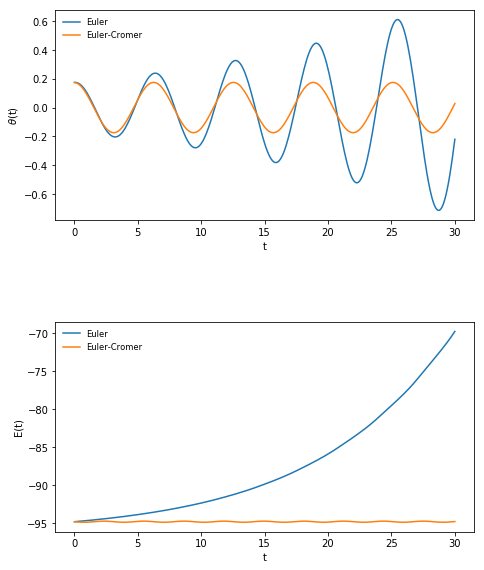

In [4]:
plot_pendulum(10)

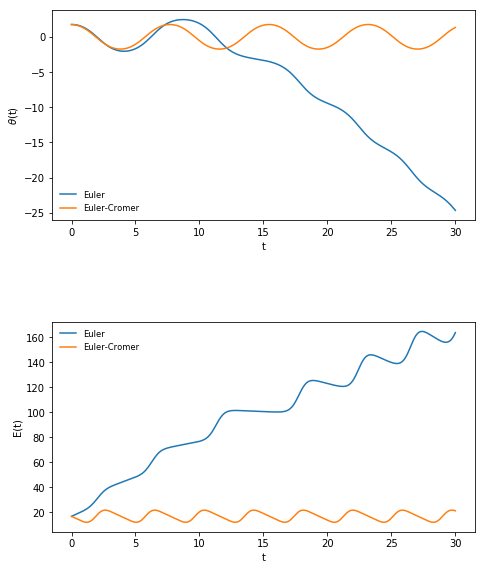

In [5]:
plot_pendulum(100)

We see that Euler-Cromer does a reasonable job conserving energy.  After each period, the energy is back to where it started, with no longterm trend of increasing energy.  The simple Euler method however does increase in energy from one period to the next.  You can see this in the amplitude plots too -- the displacement of the pendulum grows with time.

We can estimate the period just by looking at the plots, but we can also try to infer it from the sign change in omega.  This function below does this -- it looks for successive changes in the sign of omega and says that that is 1/2 of the period.  

In [6]:
p_ec = SimplePendulum(10, method="EC")
p_ec.integrate(0.1, 30)
    
sign_current = np.sign(p_ec.omega[0])
n_changes = 0
for t, o in zip(p_ec.t, p_ec.omega):
    if np.sign(o) != sign_current:
        n_changes += 1
        sign_current = np.sign(o)
        if n_changes == 1:
            t_start = t
        elif n_changes == 2:
            t_end = t
            break
        
# that should give 1/2 of the period (omega changes twice in a full period)
print("period = {}".format(2*(t_end - t_start)))

period = 6.200000000000003


For comparison, here's the analytic estimate

In [7]:
p_ec.period()

6.2951476052815529

<div style="background-color: powderblue; color: black; padding: 10px;">
b. By substituting $\theta^{n+1}$ and $\omega^{n+1}$ from the
    Euler method into the total energy expression, show that the total
    energy monotonically increases in time when the system is solved
    using Euler's method.  (If necessary, you can use the small-angle
    approximation here to simplify things). _The same is not true
      with the Euler-Cromer method, which is why it does much better_
</div>

We can start by writing out the energy after a single step:
$$E^{n+1} = \frac{1}{2}mL^2 (\omega^{n+1})^2 - mgL \cos(\theta^{n+1})$$

Now, using the small angle approximation, $\cos(\theta) \approx 1 - \theta^2/2$, so
$$E^{n+1} \approx  \frac{1}{2}mL^2 (\omega^{n+1})^2 - mgL \left (1 - \frac{(\theta^{n+1})^2)}{2}\right)$$

Now Euler's method on our system (again using the small angle approximation) is:
$$\theta^{n+1} = \theta^n + \tau \omega^n$$
$$\omega^{n+1} = \omega^n - \tau\frac{g}{L}\theta^n$$

We can substitute this into our expression for $E^{n+1}$:
$$E^{n+1} \approx  \frac{1}{2}mL^2 \left [ \omega^n - \tau\frac{g}{L}\theta^n \right ]^2 - mgL \left (1 - \frac{1}{2} \left [\theta^n + \tau \omega^n\right]^2 \right )$$

Expanding these out, we find:
$$E^{n+1} = \frac{1}{2}m L^2 (\omega^n)^2 - mgL \left ( 1 - \frac{(\theta^n)^2}{2}\right)
   + \frac{1}{2} m g \tau^2 \left [ g (\theta^n)^2 + L (\omega^n)^2 \right ]$$
   
Note that the first two terms are just $E^n$, so we have
$$E^{n+1} = E^n
   + \frac{1}{2} m g \tau^2 \left [ g (\theta^n)^2 + L (\omega^n)^2 \right ]$$

This shows that energy is not conserved.

<div style="background-color: powderblue; color: black; padding: 10px;">
c. Now consider the leapfrog method we discussed in class, in its
    _kick-drift-kick_ or _velocity Verlet_ formulation.  As we
    saw in class, this applies when the acceleration term ($\alpha$ in
    our case) does not depend on the velocity ($\omega$ for us).

    Implement this method for the simple pendulum and estimate its
    convergence by comparing the total energy after several periods to
    the initial energy for a variety of choices of $\tau$.

</div>

This is already coded up in the class above.

period =  6.29514760528
1 7.24251796289e-05
0.5 0.000413570883575
0.1 2.08794304652e-07
0.05 2.83264716682e-08
0.01 2.77216010468e-11
0.005 1.07660196951e-12
0.001 2.99889127998e-16


(1e-05, 1.0)

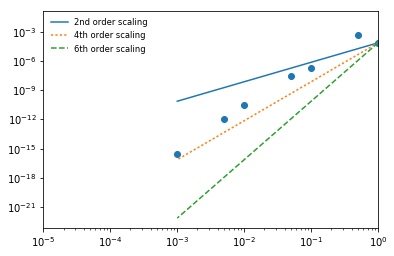

In [8]:
theta0 = 10.0

p = SimplePendulum(theta0, method="VVerlet")

# period estimate
T = p.period()
print("period = ", T)

tmax = 10.0*T
#dts = [0.5, 0.25, 0.125, 0.06125, 0.030625]
dts = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

err = []
for dt in dts:
    p.integrate(dt, tmax)

    E = p.energy()
    err.append(abs(E[-1]-E[0])/abs(E[0]))

    print(dt, abs(E[-1]-E[0])/abs(E[-1]))

plt.scatter(dts, err)

plt.plot(np.array(dts), err[0]*(dts[0]/np.array(dts))**-2, label="2nd order scaling")
plt.plot(np.array(dts), err[0]*(dts[0]/np.array(dts))**-4, ls=":", label="4th order scaling")
plt.plot(np.array(dts), err[0]*(dts[0]/np.array(dts))**-6, ls="--", label="6th order scaling")

plt.legend(frameon=False, fontsize="small")


ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlim(0.00001, 1.0)


Velocity Verlet should only be second order accurate in the variables it is integrating.  That means that velocity should converge as second order.  But since kinetic energy scales as $v^2$, the kinetic energy should converge as 4th order, so we can get better than 2nd-order scaling overall.

<div style="background-color: powderblue; color: black; padding: 10px;">
2. _Three-Body Problem_. (this is basically Newman Exercise
    8.16) Consider three stars, initially at rest, with masses and
    initial positions:
    
    
    <table>
    <tr><td>star</td><td>mass</td><td>x</td><td>y</td></tr>
    <tr><td>1</td><td>150</td><td>3</td><td>1</td></tr>
    <tr><td>2</td><td>200</td><td>-1</td><td>-2</td></tr>
    <tr><td>3</td><td>250</td><td>-1</td><td>1</td></tr>
    </table>
    All stars are in the $x$-$y$ plane, with $z = 0$.  The 
    equation of motion for star $i$ is then
    \begin{equation}
      \frac{d^2 {\bf x}_i}{dt^2} = \sum_{j = 1; j \ne i}^{3}
                G m_j \frac{{\bf x}_j - {\bf x}_i}{|{\bf x}_j - {\bf x}_i|^3}
    \end{equation}
    where $i = 1, 2, 3$, and ${\bf x}_i = (x_i, y_i)$ are the coordinates of 
    star $i$.

    <p>Write this as a system of first-order ODEs by introducing the velocity,
    ${\bf v}_i = d{\bf x}_i/dt$.  Work with $G = 1$.  
</div>

<div style="background-color: powderblue; color: black; padding: 10px;">
a.       Solve this system from $t = 0$ to $t = 2$ using the _adaptive_ 4th order Runge-Kutta method, seeking a local error
      of $\epsilon = 10^{-5}$.

      <p>Note: you may want to prevent yourself from dividing by zero if
      the stars get on top of one-another by introducing some small
      safety factor in the denominator of the force expression.  In
      N-body calculations, this is called a {\em softening length}.

      <p>Make a plot of the trajectories of the 3 stars.  
</div>

In [9]:
SMALL = 1.e-30

class Star(object):
    """ a container to hold the star positions """

    def __init__(self):
        self.t = []
        self.x = []
        self.y = []
        self.u = []
        self.v = []


class ThreeBody(object):
    """ model the gravitational interaction of three stars """

    def __init__(self, M1, pos1, M2, pos2, M3, pos3):
        """ pos is a tuple of x-y coords of the stars """

        self.G = 1  # dimensionless units

        self.pos0 = []
        self.pos0 += list(pos1)
        self.pos0 += list(pos2)
        self.pos0 += list(pos3)
        self.pos0 = np.asarray(self.pos0, dtype=np.float64)

        self.M = []
        self.M.append(M1)
        self.M.append(M2)
        self.M.append(M3)
        self.M = np.array(self.M, dtype=np.float64)

        self.stars = []

        self.N = len(self.M)

    def time(self):
        """return the time that the steps are defined at --- it is the same
        for all stars"""
        return self.stars[0].t

    def npts(self):
        """ return the number of integration points """
        return len(self.stars[0].t)

    def center_of_mass(self):
        """return the center of mass of the system at all time points"""
        Mtot = np.sum(self.M)

        x_cm = np.zeros(self.npts(), dtype=np.float64)
        y_cm = np.zeros(self.npts(), dtype=np.float64)

        for n in range(self.N):
            M = self.M[n]
            x_cm[:] = x_cm[:] + M*np.asarray(self.stars[n].x[:])
            y_cm[:] = y_cm[:] + M*np.asarray(self.stars[n].y[:])

        x_cm /= Mtot
        y_cm /= Mtot

        return x_cm, y_cm

    def rhs(self, xvec, vvec):
        """ x vec is (x1, y1, x2, y2, x3, y3) """

        xdot = []
        vdot = []
        for n in range(len(self.M)):

            xs = xvec[2*n]
            ys = xvec[2*n+1]

            us = vvec[2*n]
            vs = vvec[2*n+1]

            # compute the space derivatives
            xdot.append(us)
            xdot.append(vs)

            # compute the velocity derivatives
            vxdot = 0.0
            vydot = 0.0

            for m in range(len(self.M)):
                if n == m:
                    continue
                else:
                    xo = xvec[2*m]
                    yo = xvec[2*m+1]

                    r = np.sqrt((xo - xs)**2 + (yo - ys)**2) + SMALL
                    vxdot += self.G*self.M[m]*(xo - xs)/r**3
                    vydot += self.G*self.M[m]*(yo - ys)/r**3

            vdot.append(vxdot)
            vdot.append(vydot)

        return np.asarray(xdot), np.asarray(vdot)


    def single_step(self, xvec, vvec, t, dt):
        """ take a single RK-4 timestep from t to t+dt for the system
        ydot = rhs """

        # get the RHS at several points
        xdot1, vdot1 = self.rhs(xvec, vvec)
        xdot2, vdot2 = self.rhs(xvec + 0.5*dt*xdot1, vvec + 0.5*dt*vdot1)
        xdot3, vdot3 = self.rhs(xvec + 0.5*dt*xdot2, vvec + 0.5*dt*vdot2)
        xdot4, vdot4 = self.rhs(xvec + dt*xdot3, vvec + dt*vdot3)

        # advance
        xvec_new = xvec + (dt/6.0)*(xdot1 + 2.0*xdot2 + 2.0*xdot3 + xdot4)
        vvec_new = vvec + (dt/6.0)*(vdot1 + 2.0*vdot2 + 2.0*vdot3 + vdot4)

        return xvec_new, vvec_new


    def integrate(self, dt, err, tmax):
        """ integrate the equations of motion using 4th order R-K
            method with an adaptive stepsize, to try to achieve the
            relative error err.  dt here is the initial timestep

            if err < 0, then we don't do adaptive stepping, but rather
            we always walk at the input dt
            """

        # safety parameters
        S1 = 0.9
        S2 = 4.0

        # initial conditions
        t = 0.0
        xvec = np.asarray(self.pos0)
        vvec = np.zeros_like(xvec)

        for n in range(len(self.M)):
            star = Star()
            star.t.append(t)
            star.x.append(xvec[2*n])
            star.y.append(xvec[2*n+1])
            star.u.append(vvec[2*n])
            star.v.append(vvec[2*n+1])
            self.stars.append(star)

        # start with the old timestep
        dt_new = dt

        n_reset = 0

        while t < tmax:

            # adaptive stepping iteration loop -- keep trying to take
            # a step until we achieve our desired error
            rel_error = 1.e10

            n_try = 0
            while rel_error > err:
                dt = dt_new
                if t+dt > tmax:
                    dt = tmax-t

                # take 2 half steps
                xvec_tmp, vvec_tmp = self.single_step(xvec, vvec, t, 0.5*dt)
                xvec_new, vvec_new = self.single_step(xvec_tmp, vvec_tmp, t+0.5*dt, 0.5*dt)

                # now take just a single step to cover dt
                xvec_single, vvec_single = self.single_step(xvec, vvec, t, dt)

                # xvec_new, vvec_new should be more accurate than
                # xvec_single, vvec_single, since it used smaller
                # steps.

                # estimate the relative error now
                ex = np.abs((xvec_new - xvec_single)/(xvec_single + SMALL))
                ev = np.abs((vvec_new - vvec_single)/(vvec_single + SMALL))
                rel_error = max(ex.max(), ev.max())

                # adaptive timestep algorithm from Garcia (Eqs. 3.30
                # and 3.31)
                dt_est = dt*abs(err/rel_error)**0.2
                dt_new = min(max(S1*dt_est, dt/S2), S2*dt)

                n_try += 1

            if n_try > 1:
                # n_try = 1 if we took only a single try at the step
                n_reset += (n_try-1)

            # successful step
            t += dt

            # set for the next step
            xvec[:] = xvec_new[:]
            vvec[:] = vvec_new[:]

            # store
            for n in range(len(self.M)):
                self.stars[n].t.append(t)
                self.stars[n].x.append(xvec[2*n])
                self.stars[n].y.append(xvec[2*n+1])
                self.stars[n].u.append(vvec[2*n])
                self.stars[n].v.append(vvec[2*n+1])



The above code creates a class to integrate an N-body system, and keeps each star's info in a separate `Star` object.  Here we integrate and plot:

numer of steps: 839


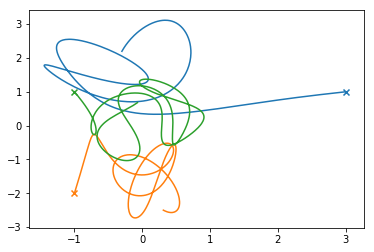

In [10]:
tb = ThreeBody(150., (3, 1),
               200., (-1, -2),
               250., (-1, 1))

tb.integrate(0.05, 1.e-6, 2.0)

print("numer of steps: {}".format(len(tb.stars[0].x)))

for i in range(tb.N):
    plt.plot(tb.stars[i].x, tb.stars[i].y)
    plt.scatter([tb.stars[i].x[0]], [tb.stars[i].y[0]], marker="x")

<div style="background-color: powderblue; color: black; padding: 10px;">
b. The center of mass of the system should remain fixed.  Compute
      the center of mass as:
      \begin{align}
        x_\mathrm{cm} &= \frac{1}{M} \sum_{i = 1}^3 m_i x_i \\
        y_\mathrm{cm} &= \frac{1}{M} \sum_{i = 1}^3 m_i y_i
      \end{align}
      where $M$ is the sum of masses.

     <p>Plot the value of the center of mass vs.\ time
      (e.g. $x_\mathrm{cm}$ vs. $t$, and $y_\mathrm{cm}$ vs. $t$).
</div>

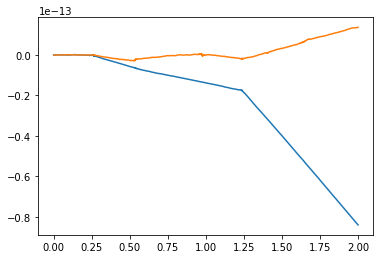

In [11]:
t = tb.time()
x_cm, y_cm = tb.center_of_mass()
plt.plot(t, x_cm, label="x center of mass")
plt.plot(t, y_cm, label="y center of mass")

Note that the center of mass was initially zero, and it stays O(1.e-13) of zero.

Let's look at the effect of the tolerance now

In [12]:
tb_low = ThreeBody(150., (3, 1),
                   200., (-1, -2),
                   250., (-1, 1))

tb_low.integrate(0.05, 1.e-2, 2.0)

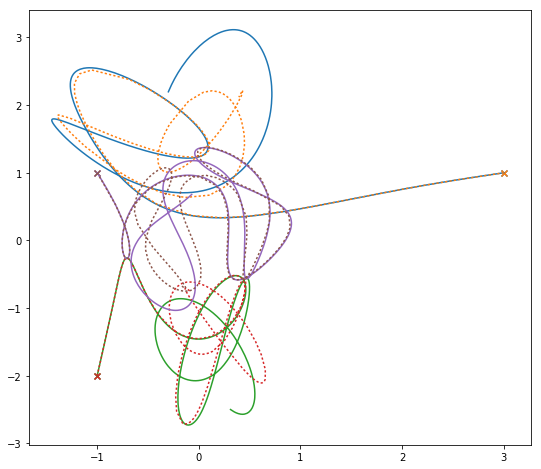

In [13]:
for i in range(tb.N):
    plt.plot(tb.stars[i].x, tb.stars[i].y)
    plt.scatter([tb.stars[i].x[0]], [tb.stars[i].y[0]], marker="x")

    plt.plot(tb_low.stars[i].x, tb_low.stars[i].y, ls=":")
    plt.scatter([tb_low.stars[i].x[0]], [tb_low.stars[i].y[0]], marker="x")
    
f=plt.gcf()
f.set_size_inches(9,8)

The dotted lines above have a much lower error tolerance.  We see that after a few close encounters, the solution changes quite a bit.